# Ensemble Evaluation: Timepoint 2 - Summer 2021

Location: New York State

Timepoint 2: July 15, 2021. Setting: New York State upon the arrival of the Delta variant. Vaccines available.

## Set up for ensemble modeling

### Load dependencies
Import functionality from the pyciemss library to allow for model sampling and calibration.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyciemss.Ensemble.interfaces import (
    load_and_sample_petri_ensemble, load_and_calibrate_and_sample_ensemble_model
)
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_and_optimize_and_sample_petri_model,
    load_and_calibrate_and_optimize_and_sample_petri_model
)
from pyciemss.visuals import plots
from pyciemss.utils import get_tspan
from pyciemss.utils.interface_utils import cdc_reformatcsv

### Collect relevant models
<!-- We have chosen x number of models to capture the relevant COVID-19 dynamics for this setting. 
 - `model1` contains compartments SEIRHD, and is stratified by age into four groups.
 - `model2` is the same as `model1`, but allows for reinfection
 - `model3` is the same as `model1`, but with a variation in transmission rate to account for masking efficacy and compliance. -->

In [6]:
from mira.sources.askenet import model_from_url
model1 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/age_vacc_var_v2.json')
model2 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/age_vacc_var_reinfection_v2.json')
model3 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/age_vacc_var_reinfection_v3.json')

## Get data

### Define a function to process the source data and produce the necessary datasets for plotting and calibration

In [7]:
def data_selector_function(data_df, train_start_row_num, train_end_row_num, forecast_end_row_num):
    '''
    This function produces three datasets: all_data, all_data1, train_data.
    '''
    all_data = data_df[train_start_row_num:forecast_end_row_num].reset_index()
    all_data = all_data.drop(columns="timestep")
    all_data = all_data.drop(columns="index")

    all_data1 = data_df[train_end_row_num:forecast_end_row_num].reset_index()
    all_data1 = all_data1.drop(columns="timestep")
    all_data1 = all_data1.drop(columns="index")

    train_data = data_df[train_start_row_num:train_end_row_num].reset_index(drop=True)
    train_data1 = train_data.assign(timepoints=[float(i) for i in range(len(train_data))])
    train_data = train_data1[["timepoints", "I", "H", "D"]]

    num_timepoints = (len(train_data) + len(all_data1))*10 + 1
    simulation_timepoints = list(get_tspan(0, (len(train_data) + len(all_data1)), num_timepoints).detach().numpy())
    
    return all_data, all_data1, train_data, simulation_timepoints

### Gather source data and set `DATA_PATH`, `RESULTS_PATH`

In [8]:
url = 'https://raw.githubusercontent.com/DARPA-ASKEM/experiments/main/thin-thread-examples/milestone_12month/evaluation/ensemble_eval_SA/datasets/aabb3684-a7ea-4f60-98f1-a8e673ad6df5/dataset.csv'
nys_data = pd.read_csv(url)
DATA_PATH = "../../notebook/ensemble_eval_sa/datasets/"
RESULTS_PATH = "../../notebook/ensemble_eval_sa/ensemble_results/"

### Create and save datasets and simulation timepoints for each forecast

In [9]:
### Forecast 1: 07/15/2021 - 08/12/2021, data: 05/01/2021 - 08/11/2021

# Forecast 1: 07/15/2021 (day 75, row 541) - 08/12/2021 (day 103, row 569), train data: 05/01/2021 (day 0, row 466) - 07/14/2021 (day 74, row 540)
[all_data1, all_data11, train_data1, timepoints1] = data_selector_function(nys_data, 465, 540, 569)
train_data1[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T2_forecast1.csv")

### Forecast 2: 07/22/2021 - 08/19/2021, data: 05/01/2021 - 07/21/2021

# Forecast 2: 07/22/2021 (day 82, row 548) - 08/19/2021 (day 110, row 576), train data: 05/01/2021 (day 0, row 466) - 07/21/2021 (day 81, row 547)
[all_data2, all_data12, train_data2, timepoints2] = data_selector_function(nys_data, 465, 547, 576)
train_data2[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T2_forecast2.csv")

### Forecast 3: 07/29/2021 - 08/26/2021, data: 05/01/2021 - 07/28/2021

# Forecast 3: 07/29/2021 (day 89, row 555) - 08/26/2021 (day 117, row 583), train data: 05/01/2021 (day 0, row 466) - 07/28/2021 (day 88, row 554)
[all_data3, all_data13, train_data3, timepoints3] = data_selector_function(nys_data, 465, 554, 583)
train_data3[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T2_forecast3.csv")

### Forecast 4: 08/05/2021 - 09/02/2021, data: 05/01/2021 - 08/04/2021

# Forecast 3: 08/05/2021 (day 96, row 562) - 09/02/2021 (day 124, row 590), train data: 05/01/2021 (day 0, row 466) - 08/04/2021 (day 95, row 561)
[all_data4, all_data14, train_data4, timepoints4] = data_selector_function(nys_data, 465, 561, 590)
train_data4[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T2_forecast4.csv")

### Plot the data

Text(0.5, 1.0, 'Cumulative Deaths per 100,000')

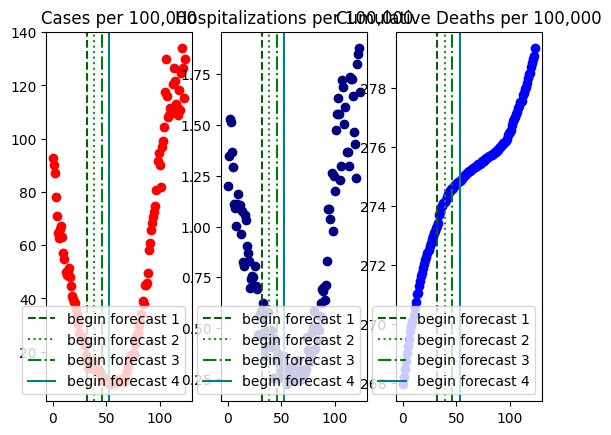

In [10]:
N = 19_340_000

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# ax1.scatter(all_data4.index, all_data4.I, color="red")
ax1.scatter(all_data4.index, 100000*(all_data4.I/N), color="red")
ax1.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax1.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax1.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax1.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax1.legend(loc='lower right')
# ax1.set_title("Cases")
ax1.set_title("Cases per 100,000")

# ax2.scatter(all_data4.index, all_data4.H, color="navy")
ax2.scatter(all_data4.index, 100000*(all_data4.H/N), color="navy")
ax2.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax2.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax2.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax2.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax2.legend(loc='lower right')
# ax2.set_title("Hospitalizations")
ax2.set_title("Hospitalizations per 100,000")

# ax3.scatter(all_data4.index, all_data4.D, color="blue")
ax3.scatter(all_data4.index, 100000*(all_data4.D/N), color="blue")
ax3.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax3.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax3.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax3.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax3.legend(loc='lower right')
# ax3.set_title("Cumulative Deaths")
ax3.set_title("Cumulative Deaths per 100,000")

# (1) Forecast 1: 07/15/2021 - 08/12/2021

## (A) Calibrate and sample an ensemble of one model

In [11]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of3_results_Jul152021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of3_quantiles_Jul152021.csv"
N_ITERATIONS = 101

### MODEL 1 - SEIRHD stratified into four age groups, vaccine status (vaccinated or unvaccinated), and variant (wild type, Delta, and Omicron)

In [12]:
num_samples = 100
models = [model1]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}] # "column name in data": "observable or state variable in model"

# Run the calibration and sampling
result1A1 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A1["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 6024.825305521488
iteration 25: loss = 4006.08810287714
iteration 50: loss = 2388.812959253788
iteration 75: loss = 2325.7081981301308
iteration 100: loss = 2319.67521494627



### Post-process results

In [ ]:
# Save results
result1A1["data"]

### MODEL 2 - SEIRHD with reinfection stratified by age, vaccination status, and variant, Model Version 2

In [ ]:
num_samples = 100
models = [model2]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}] # "column name in data": "observable or state variable in model"

# Run the calibration and sampling
result1A2 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    # method="euler",
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # # Save results
# result1A2["data"].to_csv(RESULTS_FILENAME, index=False)
# result1A2["quantiles"].to_csv(QUANTILES_FILENAME, index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A2["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process results

In [ ]:
result1A2["data"]

### MODEL 3 - SEIRHD with reinfection stratified by age, vaccination status, and variant, Model Version 3

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result1A3 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result1A3["data"].to_csv(RESULTS_FILENAME, index=False)
# result1A3["quantiles"].to_csv(QUANTILES_FILENAME, index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A3["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
result1A3["data"]

## (B) Calibrate and sample an ensemble of multiple models

In [35]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of3_results_Jul152021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of3_quantiles_Jul152021.csv"
N_ITERATIONS = 51

In [13]:
num_samples = 2
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [0.1, 0.4, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"},
                     ]

# Run the calibration and sampling
result1B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=200,
    method="euler",
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 5005.492509782314
iteration 25: loss = 3239.803328216076
iteration 50: loss = 2447.3850823044777
iteration 75: loss = 2401.3241958022118
iteration 100: loss = 2374.7385641932487
iteration 125: loss = 2362.5271474719048
iteration 150: loss = 2343.4266117215157
iteration 175: loss = 2336.758360207081



### Post-process and save results

In [ ]:
# Save results
result1B["data"]

# (2) Forecast 2: 07/22/2021 - 08/19/2021

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T2_forecast2.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result2A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2A["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of1_results_Jul222021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of1_quantiles_Jul222021.csv"
result2A["data"]

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast2.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result2B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result2B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result2B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2B["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of3_results_Jul222021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of3_quantiles_Jul222021.csv"

# (3) Forecast 3: 07/29/2021 - 08/26/2021

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T2_forecast3.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result3A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result3A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result3A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3A["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Jul292021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Jul292021.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast3.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result3B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result3B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result3B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3B["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of3_results_Jul292021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of3_quantiles_Jul292021.csv"

# (4) Forecast 4: 08/05/2021 - 09/02/2021

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T2_forecast4.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result4A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result4A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result4A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4A["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Aug052021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Aug052021.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast4.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result4B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result4B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result4B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4B["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Aug052021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Aug052021.csv"